In [1]:
import sys
sys.path.append('../')

In [2]:
from numpyro import diagnostics
import numpy as np
import matplotlib.pyplot as plt
import uq4pk_src
from jax import random
rng_key = random.PRNGKey(32743)

# Fit M54 with SVD-MCMC 

First, we set up the data:

In [3]:
m54_data = uq4pk_src.data.M54()
m54_data.logarithmically_resample(dv=50.)

ssps = uq4pk_src.model_grids.MilesSSP(
    miles_mod_directory='EMILES_BASTI_BASE_BI_FITS',
    imf_string='Ebi1.30',
    lmd_min=None,
    lmd_max=None,
    )
ssps.resample_spectra(m54_data.lmd)
# normalise the SSP templates to be light-weighted rather than mass-weighted,
ssps.Xw /= np.sum(ssps.Xw, 0)
ssps.dv = m54_data.dv
ssps.speed_of_light = m54_data.speed_of_light


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



Fit the data using ``ppxf`` to get the multiplicative polynomial correction,

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       146         3    -0.088     0.187
chi2/DOF: 0.9353; degree = -1; mdegree = 21
method = capfit; Jac calls: 9; Func calls: 241; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  22 / 636


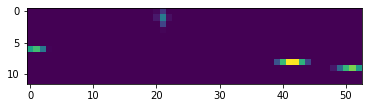

In [4]:
%matplotlib inline

def orient_image(f):
    """
    Transform the distribution function that goes into observation operator into an image
    that has the correct orientation for visualisation.
    """
    image = f
    # Have to flip.
    image = np.flipud(image)
    return image

from ppxf import ppxf

npix_buffer_mask = 20
m54_data.mask[:npix_buffer_mask] = False
m54_data.mask[-npix_buffer_mask:] = False

templates = ssps.Xw
galaxy = m54_data.y
noise = m54_data.noise_level
velscale = ssps.dv
start = [0., 30., 0., 0.]
bounds = [[-500,500], [3,300.], [-0.3,0.3], [-0.3,0.3]]
moments = 4
mask = m54_data.mask

# final pixel is NAN, breaks PPXF even though this is masked, so remove it here manually
templates = templates[:-1,:]
galaxy = galaxy[:-1]
noise = noise[:-1]
mask = mask[:-1]

ppxf_fit = ppxf.ppxf(
    templates,
    galaxy,
    noise,
    velscale,
    start=start,
    degree=-1,
    mdegree=21,
    moments=moments,
    bounds=bounds,
    regul=1e-10,
    mask=mask
)

f_ppxf = np.reshape(ppxf_fit.weights, ssps.par_dims)
im_ppxf = orient_image(f_ppxf)
plt.imshow(im_ppxf)
plt.show()

Next, correct the templates using the fitted polynomial.

In [5]:
continuum_distorition = ppxf_fit.mpoly
# add an extra element to the end of array to account for one that we chopped off earlier
continuum_distorition = np.concatenate([continuum_distorition, [continuum_distorition[-1]]])

import copy
ssps_corrected = copy.deepcopy(ssps)
ssps_corrected.Xw = (ssps_corrected.Xw.T * continuum_distorition).T

We set $\theta_v$ equal to the PPXF fit. We have to invert the sign of $h_3$.

In [6]:
theta_v = np.array([146, 3, 1., 0., 0., 0.088, 0.187])

The final element of M54 data and the noise level is `nan` and this screws things up. Simplest fix is to replace it with a non nan value. This is masked anyway - so won't make a difference to the results,

In [7]:
y = 1.*m54_data.y
y[-1] = y[-2]
sigma_y = 1.*m54_data.noise_level
sigma_y[-1] = sigma_y[-2]

## fit the spectrum

In [8]:
svd_mcmc = uq4pk_src.svd_mcmc.SVD_MCMC(
    ssps=ssps_corrected,
    Theta_v_true=theta_v,
    y=y,
    sigma_y=sigma_y,
    dv=m54_data.dv,
    mask=m54_data.mask,
    do_log_resample=False)

Distribution functions should have shape (12, 53)


In [9]:
svd_mcmc.set_q(15)

In [10]:
eta_alpha_model = svd_mcmc.get_eta_alpha_model(sigma_alpha=0.1, sigma_eta=0.1)
eta_alpha_sampler = svd_mcmc.get_mcmc_sampler(eta_alpha_model, num_warmup=500, num_samples=500)

In [11]:
eta_alpha_sampler.run(rng_key)

sample: 100%|█| 1000/1000 [00:08<00:00, 118.48it/s, 255 steps of size 1.07e-


In [12]:
eta_alpha_sampler.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      1.00      0.00      1.00      1.00      1.00    490.74      1.00
    eta[0]     -0.01      0.00     -0.01     -0.01     -0.01    418.26      1.00
    eta[1]     -0.04      0.00     -0.04     -0.04     -0.04    455.39      1.00
    eta[2]      0.05      0.00      0.05      0.05      0.05    505.03      1.00
    eta[3]     -0.05      0.00     -0.05     -0.05     -0.04    331.00      1.00
    eta[4]      0.00      0.00      0.00      0.00      0.01    495.44      1.00
    eta[5]      0.03      0.00      0.03      0.03      0.03    395.95      1.00
    eta[6]     -0.05      0.01     -0.05     -0.06     -0.04    145.18      1.02
    eta[7]     -0.03      0.01     -0.03     -0.04     -0.02    185.84      1.01
    eta[8]      0.01      0.01      0.01     -0.00      0.02    173.32      1.01
    eta[9]     -0.06      0.01     -0.06     -0.07     -0.05    203.62      1.00
   eta[10]     -0.01      0

Posterior predictive from eta and alpha,

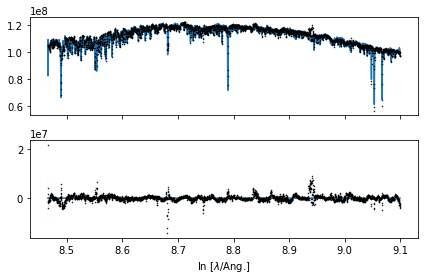

In [13]:
eta_alpha_samples = eta_alpha_sampler.get_samples()
y_smp = svd_mcmc.get_pp_from_eta_alpha(eta_alpha_samples)
_ = svd_mcmc.plot_posterior_predictve(y_smp)

## deproject

Get beta samples. Get the regulariser:

In [14]:
mask = m54_data.mask
y = m54_data.y[mask]
y_sd = m54_data.noise_level[mask]

ppxf_scale = np.linalg.norm(f_ppxf)
s = ppxf_scale
y_scaled = y / s
y_sd_scaled = y_sd / s
from uq4pk_fit.inference import ForwardOperator, StatModel
from uq4pk_fit.special_operators import OrnsteinUhlenbeck, DiscreteGradient, DiscreteLaplacian


forward_operator = ForwardOperator(hermite_order=4, mask=mask, ssps=ssps_corrected, dv=ssps_corrected.dv,
                                   do_log_resample=False)
# Fit the model
model = StatModel(y=y_scaled, y_sd=y_sd_scaled, forward_operator=forward_operator)
model.fix_theta_v(indices=np.arange(model.dim_theta), values=theta_v)
model.beta1 = 1.
model.P1 = OrnsteinUhlenbeck(m=model.m_f, n=model.n_f, h=np.array([2., 1.]))

/Users/pjethwa/miniconda3/envs/dcdirect/lib/python3.9/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


Distribution functions should have shape (12, 53)


In [15]:
beta_tilde_prior_cov = model.P1.cov/model.beta1

In [16]:
beta_tilde_model = svd_mcmc.get_beta_tilde_model(
    eta_alpha_samples=eta_alpha_samples,
    Sigma_beta_tilde=beta_tilde_prior_cov)
beta_tilde_sampler = svd_mcmc.get_mcmc_sampler(beta_tilde_model, num_warmup=500, num_samples=1000)

In [17]:
beta_tilde_sampler.run(rng_key)

sample: 100%|█| 1500/1500 [06:45<00:00,  3.70it/s, 1023 steps of size 2.02e-


In [18]:
beta_tilde_sampler.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta_tilde[0]      0.00      0.00      0.00      0.00      0.00    743.36      1.00
  beta_tilde[1]      0.00      0.00      0.00      0.00      0.00    620.51      1.00
  beta_tilde[2]      0.00      0.00      0.00      0.00      0.00    418.91      1.00
  beta_tilde[3]      0.00      0.00      0.00      0.00      0.00    585.60      1.00
  beta_tilde[4]      0.00      0.00      0.00      0.00      0.00    635.69      1.00
  beta_tilde[5]      0.00      0.00      0.00      0.00      0.00    692.84      1.00
  beta_tilde[6]      0.00      0.00      0.00      0.00      0.00    747.45      1.00
  beta_tilde[7]      0.00      0.00      0.00      0.00      0.00    898.14      1.00
  beta_tilde[8]      0.00      0.00      0.00      0.00      0.00    292.84      1.00
  beta_tilde[9]      0.00      0.00      0.00      0.00      0.00    501.69      1.00
 beta_tilde[10]      0.00      0.00      0.00      0.

Visualise the diagnostics,

In [19]:
beta_tilde_samples = beta_tilde_sampler.get_samples()
beta_tilde = np.array(beta_tilde_samples['beta_tilde'])

Check that all ESS > 100,

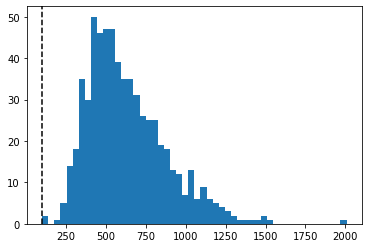

In [20]:
plt.hist(diagnostics.effective_sample_size(beta_tilde[np.newaxis,:,:]), bins=50)
plt.axvline(100, ls='--', color='k')

Check that all r_hat < 1.05,

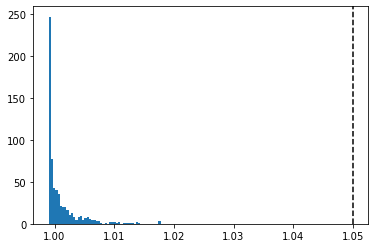

In [21]:
plt.hist(diagnostics.split_gelman_rubin(beta_tilde[np.newaxis,:,:]), bins=50)
plt.axvline(1.05, ls='--', color='k')

Posterior predictive via projected beta tilde,

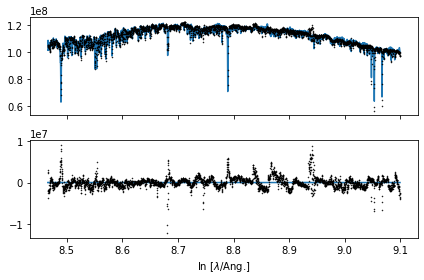

In [22]:
y_smp = svd_mcmc.get_pp_from_beta_tilde_via_lowdim(beta_tilde_samples)
_ = svd_mcmc.plot_posterior_predictve(y_smp)

Posterior predictive directly from beta tilde,

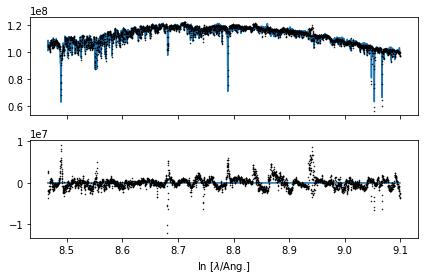

In [23]:
y_smp = svd_mcmc.get_pp_from_beta_tilde(beta_tilde_samples)
_ = svd_mcmc.plot_posterior_predictve(y_smp)

## plot pixel-wise posterior percentiles

These show pixel-wise posterior percentiles for beta i.e. the dentity *before* multiplying by the volume element, 

5th percentile,

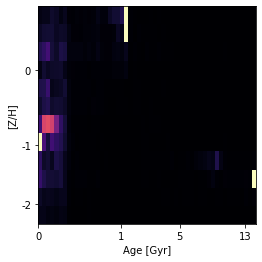

In [24]:
_ = svd_mcmc.plot_pixel_wise_posterior_percentiles(beta_tilde_samples, percentile=5, clim=(0,5e10))

median,

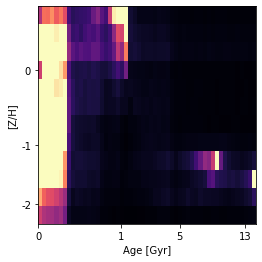

In [25]:
_ = svd_mcmc.plot_pixel_wise_posterior_percentiles(beta_tilde_samples, percentile=50, clim=(0,5e10))

95th percentile,

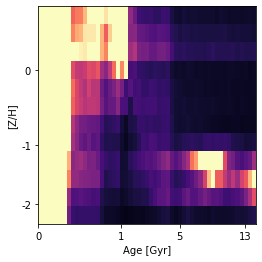

In [26]:
_ = svd_mcmc.plot_pixel_wise_posterior_percentiles(beta_tilde_samples, percentile=95, clim=(0,5e10))

## Save the samples

Save the beta samples, i.e. the dentity *before* multiplying by the volume element.

In [ ]:
beta = svd_mcmc.get_beta_from_beta_tilde(beta_tilde_samples)
np.save('m54_mcmc_samples_q15.npy', beta)

## Sample the direct model 

i.e. the full model, with no dimensionality reduction!

In [30]:
beta_tilde_direct_model = svd_mcmc.get_beta_tilde_direct_model(Sigma_beta_tilde=beta_tilde_prior_cov)
beta_tilde_direct_sampler = svd_mcmc.get_mcmc_sampler(beta_tilde_direct_model, num_warmup=500, num_samples=1000)

In [31]:
beta_tilde_direct_sampler.run(rng_key)

sample: 100%|█| 1500/1500 [39:45<00:00,  1.59s/it, 1023 steps of size 2.55e-


In [32]:
beta_tilde_direct_sampler.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta_tilde[0]      0.00      0.00      0.00      0.00      0.00   1251.82      1.00
  beta_tilde[1]      0.00      0.00      0.00      0.00      0.00   1358.94      1.00
  beta_tilde[2]      0.00      0.00      0.00      0.00      0.00    832.61      1.00
  beta_tilde[3]      0.00      0.00      0.00      0.00      0.00   1019.81      1.00
  beta_tilde[4]      0.00      0.00      0.00      0.00      0.00   1270.07      1.00
  beta_tilde[5]      0.00      0.00      0.00      0.00      0.00   1357.42      1.00
  beta_tilde[6]      0.00      0.00      0.00      0.00      0.00    963.46      1.00
  beta_tilde[7]      0.00      0.00      0.00      0.00      0.00   1207.71      1.00
  beta_tilde[8]      0.00      0.00      0.00      0.00      0.00    589.75      1.00
  beta_tilde[9]      0.00      0.00      0.00      0.00      0.00    954.30      1.00
 beta_tilde[10]      0.00      0.00      0.00      0.

Total time for complete model = 39.45 mins

Total speedup from using latent dimension =

In [37]:
(39*60+54)/(6*60+45+8)

5.796610169491525

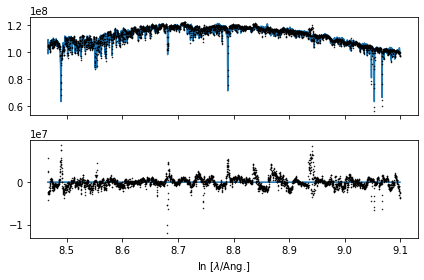

In [38]:
beta_tilde_samples = beta_tilde_direct_sampler.get_samples()
y_smp = svd_mcmc.get_pp_from_beta_tilde(beta_tilde_samples)
_ = svd_mcmc.plot_posterior_predictve(y_smp)

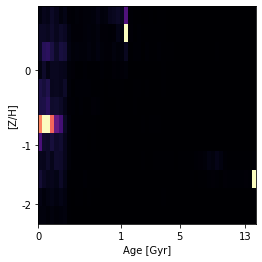

In [40]:
_ = svd_mcmc.plot_pixel_wise_posterior_percentiles(beta_tilde_samples, percentile=5, clim=(0,5e10))

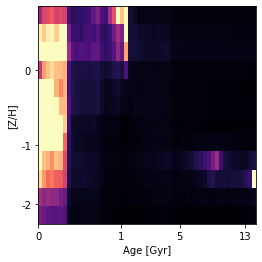

In [41]:
_ = svd_mcmc.plot_pixel_wise_posterior_percentiles(beta_tilde_samples, percentile=50, clim=(0,5e10))

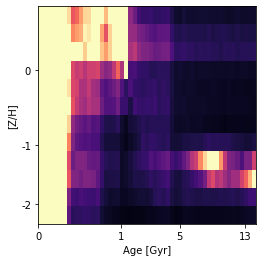

In [43]:
_ = svd_mcmc.plot_pixel_wise_posterior_percentiles(beta_tilde_samples, percentile=95, clim=(0,5e10))